# The FinBERT Model

FinBERT is a domain-specific model designed for financial sentiment analysis. It is based on the BERT architecture (Devlin et al., 2019 [3]) but was further trained on a large-scale financial coprora to better the linguistic patterns and terminology used in financial news and reports [2].

The most widely used version of the model was introduced by Araci (2019) [4], who showed that fine-tuning BERT on financial texts substantially improves sentiment classification performance compared to general-purpose language models.

The standard publicly available FinBERT model ProsusAI/finbert (on HuggingFace) [1] is finetuned to predict three sentiment classes:
* postive
* negative
* netural
and outputs a softmax distribution over these 3 labels.

## Task Overview

The goal of this section of the project is to fine-tune the FinBERT model for a 5 class sentiment classification problem on the FinGPT sentiment dataset [5]. The five classes represent a more granular sentiment scale:
* positive
* moderately positive
* neutral
* moderately negative
* negative

This additional granularity would be beneficial when financial sentiment is used in financial analysis. For example, suppose we want to predict the price of a stock and we receive two different pieces of information (at different time instances).

1. “Company X Beats Quarterly Revenue Estimates by 2%”
2. “Company X Announces Breakthrough Patent Approval for a First-in-Class Drug with Multi-Billion Dollar Market Potential”

Now obviously both of these are positive for Company X, but headline 2 would cause a much larger increase in the stock price. For a trader, being able to determine magnitude as well as direction is essential when trying to effectively hedge.

This change from 3 to 5 outputs requires adapting the FinBERT architecture to output 5 logits instead of 3. Thus this section addresses a number of key challenges that effect data scientists in many fields:

* Ovefitting
* Imbalanced dataset
* Ordinal classes

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Loading in Dataset

The dataset we are using is the FinGPT sentiment training dataset which has roughly 77K entries. Whilst this may at first seem large, in the context of nerual networks this is a very small dataset. We chose it as it is small enough for us to work with with our limited comoputing resource, and because it becomes pre labelled with 9 sentiment classes. Due to the class imbalance we reduce this down to 5 by joining some of the classes together. 

One of the difficulties that would be faced if more compute was avaliable was finding a large enough pre labelled dataset that could be used to train the finBERT model, which has approximately 110 million parameters. We show how this challenge can be mitigated in this section, as we attempt to fine-tune the finBERT model on a data set which has less than a thousandth of entries as the model has parameters.

In [ ]:
from datasets import load_dataset
ds2 = load_dataset("FinGPT/fingpt-sentiment-train", split="train")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

data/train-00000-of-00001-dabab110260ac9(…):   0%|          | 0.00/6.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76772 [00:00<?, ? examples/s]

Here we create our mapping from the 9 classes of the dataset to the 5 classes we will be predicting.

In [ ]:
mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}


In [ ]:
def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

ds2 = ds2.map(map_to_5)


Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

Here we are creating our map from our classes to the encoded labels (0-4). Note that here they are encoded by alphabetical order rather than in their ordinal relation:

0. : moderate_negative
1. : moderate_positive
2. : negative
3. : neutral
4. : positive


 We do this to demonstrate one of the weaknesses of the vanilla finBERT model, which was trained using Categorical Cross-Entropy Loss - in particular that it doesn't care about ordinality. In other words, say the true value $y_i$ is positive, with cross-entropy loss, if $y_i$ is predicted as negative that is just as bad as being predicted as moderately positive, which is clearly not equivalent. Therefore, currently it is not necessary to care about the mapping preserving ordinality. In section 1.3 we will explore this further.

In [ ]:
unique_new = sorted(list(set(ds2["label_5"])))
id2label = {i: lab for i, lab in enumerate(unique_new)}
label2id = {lab: i for i, lab in id2label.items()}

def encode_label(example):
    example["label"] = label2id[example["label_5"]]
    return example

ds2 = ds2.map(encode_label)


Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

Importing the pretrained model from HuggingFace and reconfigure so that the output layer has 5 outputs.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now we check the balance of our dataset. We also show the balance of the dataset before our mapping. As the 'strong' classes were so small they were joined with positive and negative respectfully, and mildy and moderate were joined together.

This is still imbalanced but improved. For example, neutral is about 38% of the dataset and moderate negative only around 6%. The dataset is still dominated by negative, positive and neutral.

In [ ]:
import pandas as pd

# Convert to pandas for easy counting
df = pd.DataFrame(ds2)

# Before mapping (original 9 classes)
print("Original 9-class distribution:")
print(df["output"].value_counts())
print(df["output"].value_counts(normalize=True))

# After mapping (5-class)
print("\nMapped 5-class distribution:")
print(df["label_5"].value_counts())
print(df["label_5"].value_counts(normalize=True))


Original 9-class distribution:
output
neutral                29215
positive               21588
negative               11749
moderately positive     6163
moderately negative     2972
mildly positive         2548
mildly negative         2108
strong negative          218
strong positive          211
Name: count, dtype: int64
output
neutral                0.380542
positive               0.281196
negative               0.153038
moderately positive    0.080277
moderately negative    0.038712
mildly positive        0.033189
mildly negative        0.027458
strong negative        0.002840
strong positive        0.002748
Name: proportion, dtype: float64

Mapped 5-class distribution:
label_5
neutral              29215
positive             21799
negative             11967
moderate_positive     8711
moderate_negative     5080
Name: count, dtype: int64
label_5
neutral              0.380542
positive             0.283945
negative             0.155877
moderate_positive    0.113466
moderate_negative   

Now we tokenize our inputs and create a 80/20 train/validation split so that we can evaluate how the model performs on unseen data, to help prevent overfitting. Overfitting is a serious challenge due the imbalances in the dataset, and the size of the dataset relative to the number of parameters.

In [ ]:
def tokenize(batch):
    return tokenizer(batch["input"], truncation=True, padding="max_length", max_length=128)

ds2 = ds2.map(tokenize, batched=True)
ds2 = ds2.train_test_split(test_size=0.2)   # create validation set

ds2 = ds2.remove_columns(["output", "label_5", "input"])  # keep only tokenized fields + label
ds2.set_format("torch")


Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

This function records the training accuracy at each epoch which allows us to plot train/validation accuracy plots later.

In [ ]:
from transformers import TrainerCallback
import numpy as np

class TrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None  # Will be set after Trainer initialization

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            # This case should ideally not be reached if setup correctly
            raise ValueError("Trainer instance not set in TrainAccuracyCallback.")

        train_ds = self.trainer.train_dataset

        # Get predictions on the training set
        preds_output = self.trainer.predict(train_ds, metric_key_prefix="train")
        logits = preds_output.predictions
        labels = preds_output.label_ids
        preds = np.argmax(logits, axis=1)

        # Compute accuracy
        train_acc = (preds == labels).mean()

        # Log accuracy into trainer history
        self.trainer.state.log_history.append({
            "epoch": state.epoch,
            "train_accuracy": train_acc,
            "step": state.global_step
        })

        print(f"Training Accuracy (epoch {state.epoch:.0f}): {train_acc:.4f}")

## Training the Model

Now we are tuning our model to give 5 outputs. The initial parameters chosen are just for exploring how the model performs initially and will then be fine tuned further in later sections. Training for 5 epochs took roughly 1 hour to complete using a GPU in colab.

As we have already mentioned one of the biggest difficulties in training this model is to prevent overfitting. 

In [ ]:

from transformers import TrainingArguments, Trainer
import numpy as np
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}

training_args = TrainingArguments(
    output_dir="./finbert_5class",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)

# Instantiate the custom callback
train_acc_callback = TrainAccuracyCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[train_acc_callback] # Pass the instance here
)

# After the Trainer is initialized, assign the trainer instance to the callback
train_acc_callback.trainer = trainer

trainer.train()

/tmp/ipython-input-1846616030.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.260700,0.233168,0.928232
2,0.171300,0.226477,0.939173
3,0.107800,0.262109,0.944774
4,0.053400,0.312404,0.943797
5,0.036400,0.342274,0.943015


Training Accuracy (epoch 1): 0.9554
Training Accuracy (epoch 2): 0.9779
Training Accuracy (epoch 3): 0.9875
Training Accuracy (epoch 4): 0.9928
Training Accuracy (epoch 5): 0.9951


TrainOutput(global_step=19195, training_loss=0.14955175953254193, metrics={'train_runtime': 3113.741, 'train_samples_per_second': 98.623, 'train_steps_per_second': 6.165, 'total_flos': 2.019990869463936e+16, 'train_loss': 0.14955175953254193, 'epoch': 5.0})

## Evaluating Model Performance

First we plot the training accuracy and the validation accuracy. From this plot we can see clear evidence of overfitting as the validation loss begins to explode, whilst training loss continues to decrease [6]. This indicates we may need to increase regularisartion ($L^2$ weight decay), introduce early stopping and reduce the learning rate/ tune batch size.

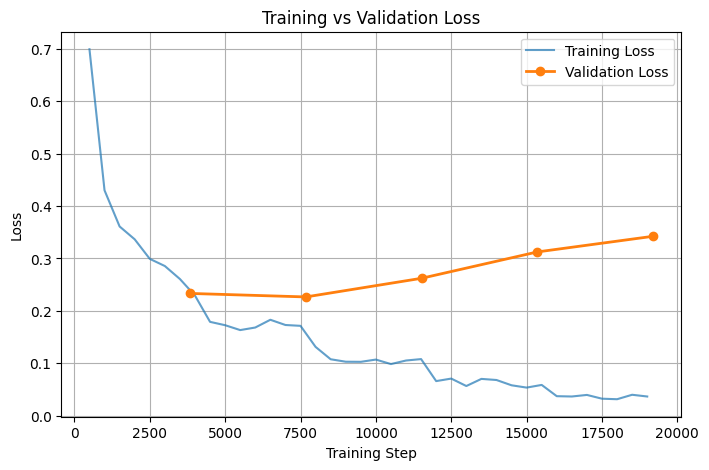

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load logs
logs = pd.DataFrame(trainer.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



If we consider the accuracy plots as well we uncover another interesting trend. Despite validation loss increasing we still see validation accuracy also increasing. This behaviour is common in multiclass setups with cross-entropy loss, particularly when the model becomes over confident in its predictions. The new 5-class setting introduces a more imbalanced labeled distribution, causing the model to assign increasingly extreme probabilities to the majority classes (negative, neutral, positive). Accuracy improves because the argmax is still often correct, but the validation loss rises as the softmax outputs become sharply peaked and porrly calibrated on minority classes, reflecting the overconfident overfitting. Whenever the model is wrong the loss is larger because it was overconfident in its wrong prediction.

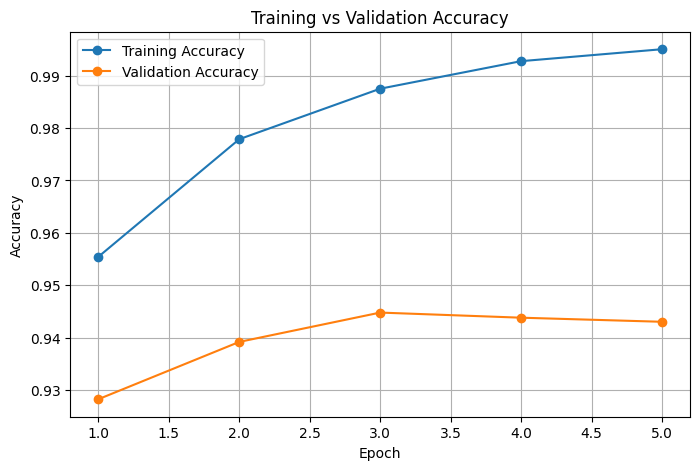

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

train_acc = logs.dropna(subset=["train_accuracy"])
eval_acc = logs.dropna(subset=["eval_accuracy"])

plt.figure(figsize=(8,5))

plt.plot(train_acc["epoch"], train_acc["train_accuracy"], marker="o", label="Training Accuracy")
plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], marker="o", label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()



This overfitting can be seen further when considering the F1-score of each class. The precision and recall of the majority classes is very high (0.95-0.98) so it predicts these classes accurately, but struggles in comparison with the moderate classes (0.81-0.83).

In [ ]:
preds = trainer.predict(ds2["test"])
pred_labels = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(preds.label_ids, pred_labels, target_names=list(id2label.values())))


                   precision    recall  f1-score   support

moderate_negative       0.83      0.81      0.82      1066
moderate_positive       0.81      0.85      0.83      1681
         negative       0.98      0.97      0.98      2452
          neutral       0.95      0.95      0.95      5722
         positive       0.98      0.98      0.98      4434

         accuracy                           0.94     15355
        macro avg       0.91      0.91      0.91     15355
     weighted avg       0.94      0.94      0.94     15355



The confusion matrix futher shows that it struggles to distinguish between the moderate classes and neutral. Whilst this is perhaps understandable it is something we aim to improve on. The more worrying misclassifications are when postive is predicted as negative and vice versa. Identifying when the model is confused will be a key focus of section 1.4.

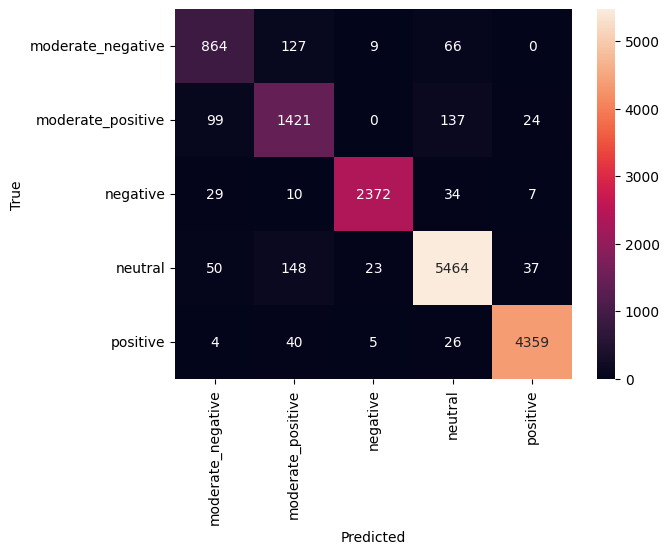

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(preds.label_ids, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
trainer.save_model("/content/drive/MyDrive/finbert_5class_model")
tokenizer.save_pretrained("/content/drive/MyDrive/finbert_5class_model")


('/content/drive/MyDrive/finbert_5class_model/tokenizer_config.json',
 '/content/drive/MyDrive/finbert_5class_model/special_tokens_map.json',
 '/content/drive/MyDrive/finbert_5class_model/vocab.txt',
 '/content/drive/MyDrive/finbert_5class_model/added_tokens.json',
 '/content/drive/MyDrive/finbert_5class_model/tokenizer.json')

# Fine-tune 2 - Regularization to prevent Overfitting

In this section we aim to address some of the issues related to the imbalanced dataset and the large amount of overfitting due to the model size compared with the size of our data set

## Weighted Trainer

### Standard Cross-Entropy Loss
Standard cross-entropy assumes each class is equally important, and every misclassication contributes equally to the loss. For C classes we have:

$$\mathcal{L}_{\text{CE}}
= - \sum_{c=1}^{C} y_{c} \, \log p_{c}$$

This is the loss function we used in our first fine-tune and caused our model to become biased towards predicting the majority classes.

### Weighted Cross-Entropy Loss

Weighted cross-entropy modifies the loss by multiplying each class term by a class specific weight:

$$
\mathcal{L}_{\text{WCE}}
= - \sum_{c=1}^{C} w_{c} \, y_{c} \, \log p_{c}
$$

Smaller classes receive higher weights, amplifying their contribution. This directly counteracts the bias towards majority classes. We implement the widely used inverse class frequency approach [7]:

$$w_c = \frac{N}{C \, n_c}$$

where $N$ is the total number of training samples and $n_c$ is the number of samples in class $c$. This increases the gradient contributions for low-frequency labels such as the moderate classes, encouraging a more uniform performance.

## Regularization

Many of these techniques and their explanations are adapted from [6].

### Freezing first 8 Layers

This stops the first 8 transformer laters from updating during training. Only the later layers and classification head are tuned. The early layers of FinBERT will capture the general language features such as syntax which we don't want to relearn. By freezing them, we reduce the number of trainable parameters which is cruicial due to our relatively small model size.

### Increasing dropout

This randomly sets a proportion of neurons to 0 during training. This forces the model to not rely on any single feature or neuron. This encourages redundant representations, which makes the model more robust and less likely to memorise specific patterns in the training set. This prevents the classifier head from over specialising on the majority classes.

### Reducing learning rate 

Wilson et al. [8] discuss the trade-offs associated with raising/ lowering the learning rate.  Too large a learning rate can cause overshooting of minima, instability and poor generalisation. However, too small a learning rate increases training time unnecessarily, without improving accuracy beyond a certain point. This study supports the choice of reducing learning rates and using warm-up in fine-tuning FinBERT. Lower learning rates allow large pre-trained models to adapt smoothly to small datasets and prevent overfitting, improving generalization to unseen data.

This paper also suggests an algorithm for how to systematically choose the learning rate. Due to the limitations of our computing resource we have not followed this as it would require retraining the neural network multiple times, however, it would be something to consider if more compute was available.

### Warm-up Steps

This gradually increases the learning rate from 0 to the target value over the first few steps of training, and is an alternative to the algorith discussed above. It prevents large, sudden weight updates at tge start whuch could destabilise the pretrained model. This means the model can slowly adapt to the task-specific data, reducing overfitting caused by aggressive early updates.

### Introducing Early Stopping

This stops training when the validation performance stops improving for a predefined number of epochs (we use 2). As overfitting occurs when the model starts to learn idiosyncrasies of the training set rather than generalisable patterns, if we halt training as soon as validation loss stops decreasing, we hopefully stop it from overfitting to the majority classes.

### Weight Decay

Whilst we keep weight decay constant here, it is important to discusss how it works. Weight decay is essentially L2 regularisation. In standard gradient descent, we minimise the training loss $\mathcal{L}(\theta)$ with resoect to the model parameters $\theta$. With weight decay the objective becomes 

$$\mathcal{L}_{\text{reg}}(\theta)=\mathcal{L}(\theta)+ \frac{\lambda}{2} \| \theta \|^2_2.$$

This shrinks weights towards zero on every step, which reduces the model's capacity to fit noise, which is especially important for large models like FinBERT on small datasets.


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import numpy as np
from evaluate import load
from torch.nn import CrossEntropyLoss


metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}

# Freeze lower layers 
for param in model.bert.encoder.layer[:8].parameters():  # freeze first 8 layers
    param.requires_grad = False

#  Adjust dropout
model.bert.config.hidden_dropout_prob = 0.2
model.bert.config.attention_probs_dropout_prob = 0.2

#  Compute class weights dynamically 
labels_array = np.array(ds2["train"]["label"])
num_classes = len(np.unique(labels_array))
class_counts = np.bincount(labels_array, minlength=num_classes)
total = labels_array.shape[0]

# Inverse frequency weights
inv_weights = total / (num_classes * class_counts)
class_weights = torch.tensor(inv_weights, dtype=torch.float32).to(model.device)

print("Class weights:", class_weights)

#  Weighted Trainer 
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        # Ensure class_weights is on the same device as logits
        loss_fct = CrossEntropyLoss(weight=class_weights.to(outputs.logits.device))
        loss = loss_fct(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss


#  Training arguments for second model 
second_model_dir = "/content/drive/MyDrive/finbert_5class_v2"
training_args = TrainingArguments(
    output_dir=second_model_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    warmup_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
    save_total_limit=2,
    load_best_model_at_end=True,       # restore best model automatically
    metric_for_best_model="eval_loss",  # monitor validation loss for early stopping
    greater_is_better=False,            # lower loss is better
    max_grad_norm=1.0                   # gradient clipping
)

#  Callbacks 
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)
callbacks_list = [train_acc_callback, early_stopping]

#  Trainer 
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=callbacks_list
)

# Assign trainer instance to callback if needed
train_acc_callback.trainer = trainer

#  Start training 
trainer.train()

#  Save final trained model separately 
trainer.save_model(second_model_dir)
tokenizer.save_pretrained(second_model_dir)

print(f"Second FinBERT model saved to {second_model_dir}")



Class weights: tensor([3.0601, 1.7473, 1.2910, 0.5229, 0.7074], device='cuda:0')


/tmp/ipython-input-2430234931.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.038500,0.569254,0.942234
2,0.029400,0.616837,0.943601
3,0.014700,0.724726,0.941322


Training Accuracy (epoch 1): 0.9963
Training Accuracy (epoch 2): 0.9974
Training Accuracy (epoch 3): 0.9982
Second FinBERT model saved to /content/drive/MyDrive/finbert_5class_v2


Despite the number of changes made the model is still extremely overfitting. The validation loss increases immediately and so the training finishes after the 3rd round with the model found at the initial epoch saved. This indicates that a longer warmup and even smaller learning rate may be appropriate. 

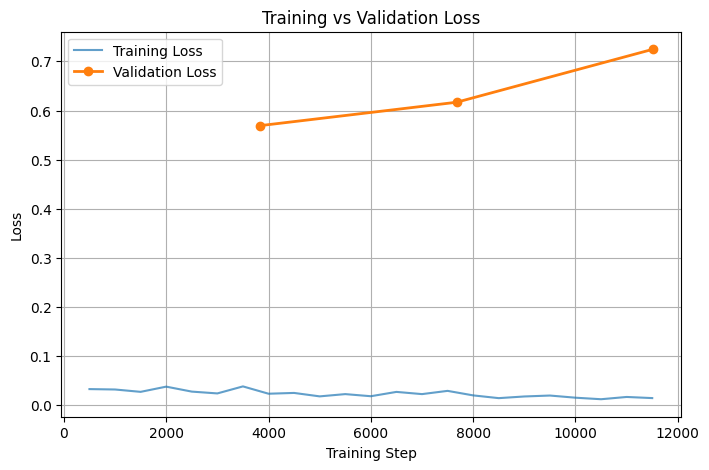

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load logs
logs = pd.DataFrame(trainer.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

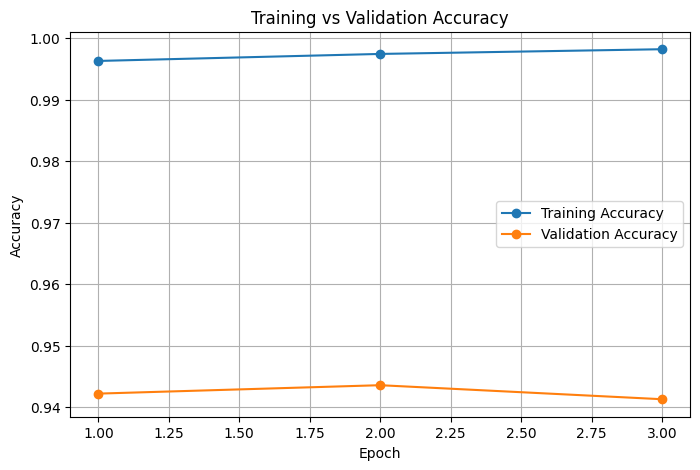

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

train_acc = logs.dropna(subset=["train_accuracy"])
eval_acc = logs.dropna(subset=["eval_accuracy"])

plt.figure(figsize=(8,5))

plt.plot(train_acc["epoch"], train_acc["train_accuracy"], marker="o", label="Training Accuracy")
plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], marker="o", label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
preds = trainer.predict(ds2["test"])
pred_labels = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(preds.label_ids, pred_labels, target_names=list(id2label.values())))

                   precision    recall  f1-score   support

moderate_negative       0.80      0.84      0.82      1066
moderate_positive       0.84      0.82      0.83      1681
         negative       0.98      0.97      0.97      2452
          neutral       0.95      0.95      0.95      5722
         positive       0.99      0.98      0.99      4434

         accuracy                           0.94     15355
        macro avg       0.91      0.91      0.91     15355
     weighted avg       0.94      0.94      0.94     15355



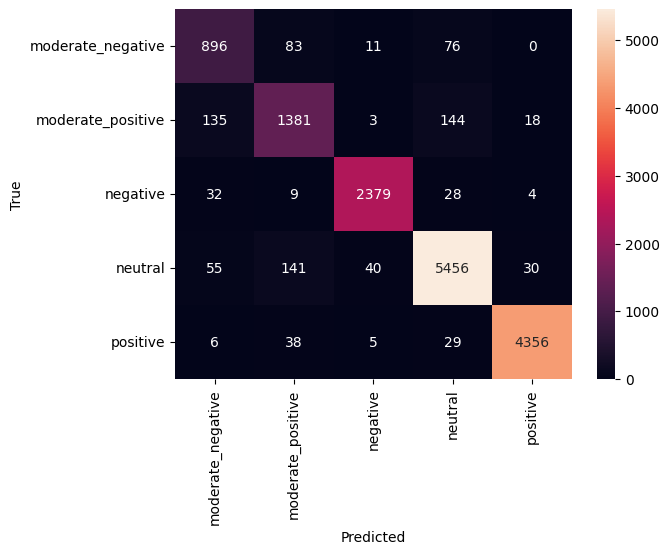

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(preds.label_ids, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Conclusion

Both models achieve 94% overall accuracy with nearly identical macro and weighted averages. The main differences are minor trade-offs in precision and recall for the moderate classes, with Model 2 slightly better at moderate_negative recall and positive precision, and Model 1 slightly better at moderate_positive recall and negative F1.

Ultimately both models are very overfitting and more aggressive regularisation is required. This is completed in sections 1.2-1.4.

# References

* [1] https://huggingface.co/ProsusAI/finbert
* [2] Malo, Pekka, et al. "Good debt or bad debt: Detecting semantic orientations in economic texts." Journal of the Association for Information Science and Technology 65.4 (2014): 782-796.
* [3] Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." Proceedings of the 2019 conference of the North American chapter of the association for computational linguistics: human language technologies, volume 1 (long and short papers). 2019.
* [4] Araci, Dogu. "Finbert: Financial sentiment analysis with pre-trained language models." arXiv preprint arXiv:1908.10063 (2019).
* [5] https://huggingface.co/datasets/FinGPT/fingpt-sentiment-train
* [6] Goodfellow, Bengio & Courville (2016). Deep Learning. MIT Press https://www.deeplearningbook.org/
* [7] Cui, Yin, et al. "Class-balanced loss based on effective number of samples." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2019.
* [8] Wilson, D. Randall, and Tony R. Martinez. "The need for small learning rates on large problems." IJCNN'01. International Joint Conference on Neural Networks. Proceedings (Cat. No. 01CH37222). Vol. 1. IEEE, 2001.